In [406]:
import pandas 
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from geopy.distance import geodesic
from haversine import haversine, Unit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import ElasticNet, RidgeCV, LassoCV, LinearRegression

Проверим датафрейм на наличие пропусков:

In [407]:
train = pandas.read_csv("/kaggle/input/lab-2-linear-regression/train.csv")
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [408]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


In [409]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1021050 non-null  object 
 1   vendor_id           1021050 non-null  int64  
 2   pickup_datetime     1021050 non-null  object 
 3   dropoff_datetime    1021050 non-null  object 
 4   passenger_count     1021050 non-null  int64  
 5   pickup_longitude    1021050 non-null  float64
 6   pickup_latitude     1021050 non-null  float64
 7   dropoff_longitude   1021050 non-null  float64
 8   dropoff_latitude    1021050 non-null  float64
 9   store_and_fwd_flag  1021050 non-null  object 
 10  trip_duration       1021050 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 85.7+ MB


In [410]:
test = pandas.read_csv("/kaggle/input/lab-2-linear-regression/test.csv")
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

Мы видим, что у тестового набора данных отсутствует столбец "dropoff_datetime", а значит его можно убрать из тренировочного набора данных, так как он не будет доступен при прогнозировании. Это нужно, чтобы тренировочные данные совпадали по структуре с тестовыми.

In [411]:
train = train.drop(columns="dropoff_datetime")

Построим гистограмму длительности поездок для оценки распределения, чтобы понять, есть ли выбросы (аномально длинные или короткие поездки):

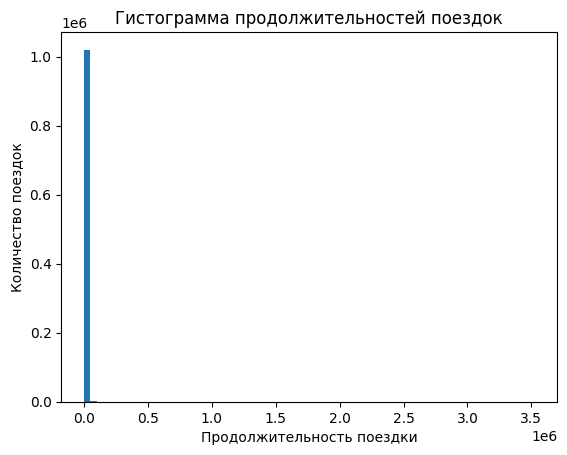

In [412]:
plt.hist(train["trip_duration"], bins=70)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

По диаграмме сложно что-либо понять из-за выбросов. Уберем их, использовуя метод IQR (межквартильного размаха) для определения выбросов, чтобы оставить только центральные значения распределения, игнорируя крайние значения:

In [413]:
Q1 = train["trip_duration"].quantile(0.2)
Q3 = train["trip_duration"].quantile(0.85)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train = train[(train["trip_duration"] >= lower_bound) & (train["trip_duration"] <= upper_bound)]

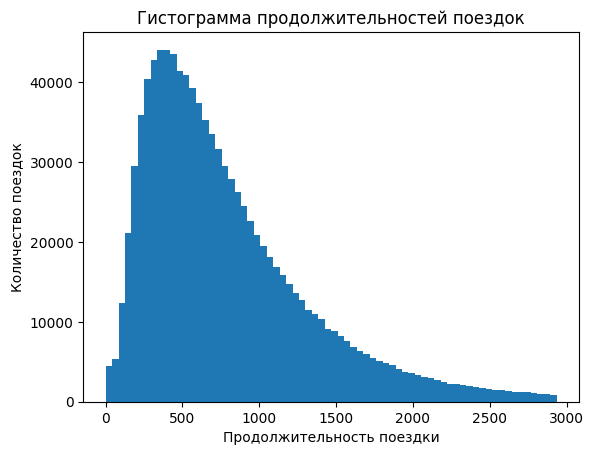

In [414]:
plt.hist(train["trip_duration"], bins=70)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Гистограмма похожа на нормальное распределение, но оно скошенное. Логарифмирование помогает преобразовать скошенное распределение длительности поездок в более нормальное, чтобы модель лучше справлялась с вариацией длительностей поездок, особенно с более длинными:

In [415]:
train["trip_duration"] = np.log(train['trip_duration'] + 1)

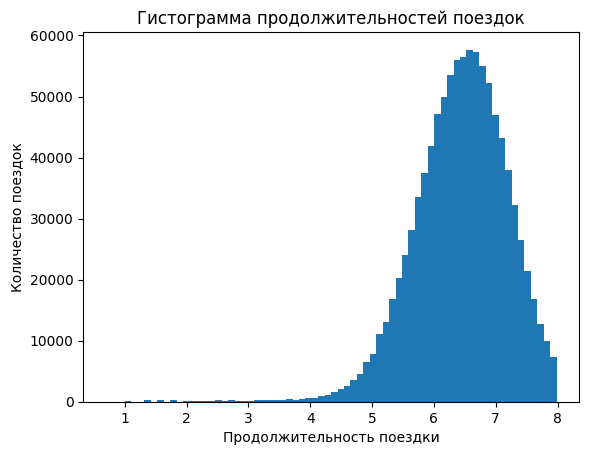

In [416]:
plt.hist(train["trip_duration"], bins=70)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Посчитаем корреляцию между параметрами и таргетом, используя функцию "corr()".
Значения корреляции будем интерпретировать следующим образом:
- 0.0–0.2: Очень слабая или отсутствующая корреляция.
- 0.2–0.4: Слабая корреляция.
- 0.4–0.6: Умеренная корреляция.
- 0.6–0.8: Сильная корреляция.
- 0.8–1.0: Очень сильная корреляция.

# vendor_id

In [417]:
correlation = train["trip_duration"].corr(train["vendor_id"])
print(f"Корреляция между vendor_id и trip_duration: {correlation:.2f}")

Корреляция между vendor_id и trip_duration: 0.01


Корреляция в районе 0.01 фактически не дает информации о связи между переменными, поэтому удаление "vendor_id" как признака из данных для модели оправдано.

In [418]:
train = train.drop(columns="vendor_id")

# passenger_count

In [419]:
correlation = train["trip_duration"].corr(train["passenger_count"])
print(f"Корреляция между passenger_count и trip_duration: {correlation:.2f}")

Корреляция между passenger_count и trip_duration: 0.02


Ситуация аналогична "vendor_id", поэтому снова удаляем признак.

In [420]:
train = train.drop(columns="passenger_count")

# store_and_fwd_flag

In [421]:
correlation = train["trip_duration"].corr(train["store_and_fwd_flag"].apply(lambda x: 1 if x == 'Y' else 0))
print(f"Корреляция между store_and_fwd_flag и trip_duration: {correlation:.2f}")

Корреляция между store_and_fwd_flag и trip_duration: 0.01


Снова корреляция близка к 0 => признак не имеет линейной зависимости с целевой переменной и его можно безопасно удалить:

In [422]:
train = train.drop(columns="store_and_fwd_flag")

In [423]:
train

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146
...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147


# pickup_datetime

Так как данный формат данных не даёт ничего полезного, разделим столбец "pickup_datetime" на столбцы c месяцем, днем недели и временем суток.

Так как месяц - категориальная величина, я воспользуюсь простейшим методом - One-Hot Encoding, чтобы модель более точно предсказывала данные на основании месяцев.

Конвертируем время в формат datetime и добавляем столбцы с годом и месяцем

In [424]:
datetime_info = pandas.to_datetime(train['pickup_datetime'])
train['year'] = datetime_info.dt.year
train['month'] = datetime_info.dt.month

Преобразуем месяц в набор бинарных столбцов

In [425]:
train = pandas.get_dummies(train, columns=['month'], prefix='month')

Добавим информацию о днях недели

In [426]:
train['day_of_week'] = datetime_info.dt.day_of_week
train = pandas.get_dummies(train, columns=['day_of_week'], prefix='day_of_week')

Преобразуем булевы столбцы в целочисленный формат

In [427]:
bool_columns = train.select_dtypes(include='bool').columns
train[bool_columns] = train[bool_columns].astype(int)

Добавим временные интервалы: утро, день, вечер, ночь

In [428]:
train['hour'] = datetime_info.dt.hour
train['morning'] = ((train['hour'] >= 6) & (train['hour'] <= 12)).astype(int)
train['day'] = ((train['hour'] >= 13) & (train['hour'] <= 17)).astype(int)
train['evening'] = ((train['hour'] >= 18) & (train['hour'] <= 23)).astype(int)
train['night'] = ((train['hour'] >= 0) & (train['hour'] <= 5)).astype(int)

Удаляем больше ненужные столбцы

In [429]:
train = train.drop(columns=['hour', 'pickup_datetime'])

# Вычисление расстояния между точками

Расстояние между точками отправления и назначения помогает определить, насколько длительной может быть поездка. Для оценки расстояния применим геодезические вычисления на основе координат

Добавляем столбец с расстоянием, используя geopy

In [430]:
train['distance_km'] = train.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).kilometers, axis=1)

Преобразуем расстояние с помощью логарифмической функции для снижения влияния выбросов

In [431]:
train['distance_log'] = np.log1p(train['distance_km'])

Визуализация зависимости расстояния от продолжительности поездки

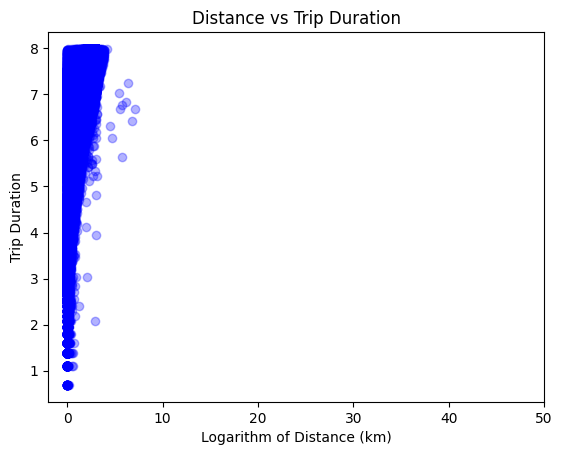

In [432]:
plt.scatter(train['distance_log'], train['trip_duration'], alpha=0.3, c='blue')
plt.xlabel('Logarithm of Distance (km)')
plt.ylabel('Trip Duration')
plt.title('Distance vs Trip Duration')
plt.xlim(-2, 50)
plt.show()

Удаляем ненужные столбцы с координатами и идентификатором

In [433]:
columns_to_remove = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'id']
train.drop(columns=columns_to_remove, inplace=True)

Проверяем корреляцию между расстоянием и длительностью поездки

In [434]:
correlation = train['distance_log'].corr(train['trip_duration'])
print(f"Корреляция между log(distance) и trip duration: {correlation:.2f}")

Корреляция между log(distance) и trip duration: 0.75


# Разделение данных на обучающую и тестовую выборки

In [435]:
target = train['trip_duration']
features = train.drop(columns=['trip_duration'])
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Подбор модели

Настройка модели ElasticNet с подбором гиперпараметров

In [436]:
elastic_net = ElasticNet()
elastic_params = {'alpha': np.logspace(-3, 2, 50), 'l1_ratio': [0.5]}
elastic_search = RandomizedSearchCV(elastic_net, elastic_params, cv=5, scoring='neg_mean_squared_error', n_iter=50, random_state=42)
elastic_search.fit(X_train, Y_train)
elastic_best = elastic_search.best_estimator_

Ridge и Lasso с автоматическим подбором параметров через RidgeCV и LassoCV

In [437]:
ridge_best = RidgeCV(alphas=np.logspace(-3, 2, 10), cv=5, scoring='neg_mean_squared_error').fit(X_train, Y_train)
lasso_best = LassoCV(alphas=np.logspace(-3, 2, 10), cv=5).fit(X_train, Y_train)

Сравнение моделей

In [438]:
for model, name in zip([LinearRegression(), ridge_best, lasso_best, elastic_best], ['Linear', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, predictions))
    print(f'RMSE for {name}: {rmse:.4f}')

RMSE for Linear: 0.4700
RMSE for Ridge: 0.4700
RMSE for Lasso: 0.4709
RMSE for ElasticNet: 0.4704


Все модели показывают примерно одинаковый результат, и из них я решил выбрать Ridge, т.к. она более стабильна при работе с высоко коррелированными признаками (мультиколлинеарностью) благодаря L2-регуляризации

# Подготовка тестовых данных

In [439]:
# Удаление неинформативных столбцов
columns_to_remove = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
test = test.drop(columns=columns_to_remove)

# Преобразование формата времени
test['pickup_datetime'] = pandas.to_datetime(test['pickup_datetime'])

# Извлечение временных характеристик
test['month'] = test['pickup_datetime'].dt.month
test['day_of_week'] = test['pickup_datetime'].dt.day_of_week
test['hour'] = test['pickup_datetime'].dt.hour

# Используем обученный на тренировочных данных OneHotEncoder
encoded_features = encoder.transform(test[['month', 'day_of_week']])
encoded_df = pandas.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['month', 'day_of_week']), index=test.index)
test = pandas.concat([test, encoded_df], axis=1)

# Добавление временных интервалов
test['morning'] = ((test['hour'] >= 6) & (test['hour'] <= 12)).astype(int)
test['day'] = ((test['hour'] >= 13) & (test['hour'] <= 17)).astype(int)
test['evening'] = ((test['hour'] >= 18) & (test['hour'] <= 23)).astype(int)
test['night'] = ((test['hour'] >= 0) & (test['hour'] <= 5)).astype(int)

# Удаление временного столбца 'hour' и исходного времени
test = test.drop(columns=['hour', 'pickup_datetime'])

# Вычисление расстояния по формуле Хаверсина
test['distance_km'] = test.apply(
    lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']),
                          (row['dropoff_latitude'], row['dropoff_longitude']),
                          unit=Unit.KILOMETERS), axis=1)

# Логарифмирование расстояния для устранения влияния выбросов
test['distance_log'] = np.log1p(test['distance_km'])

# Сохраняем идентификаторы для финального ответа
answer = test[['id']].copy()

# Удаление неиспользуемых признаков
unused_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'id']
test = test.drop(columns=unused_columns)

# Убедимся, что тестовые данные имеют те же признаки, что и обучающие
missing_cols = set(X_train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0  # Добавляем недостающие признаки с нулями

# Перестраиваем порядок столбцов в тестовых данных
test = test[X_train.columns]

In [440]:
# Предсказание с использованием Ridge и обратное преобразование логарифма
test_predictions = np.expm1(ridge_best.predict(test))

# Создание итогового DataFrame с результатами
output = pandas.DataFrame({
    'id': answer['id'], 
    'trip_duration': test_predictions
})

# Сохранение результата в CSV
output.to_csv("submission.csv", index=False)